In [23]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [25]:
end = datetime.now()
start = '2020-01-01'
df = yf.download('AAPL', start, end)

[*********************100%***********************]  1 of 1 completed


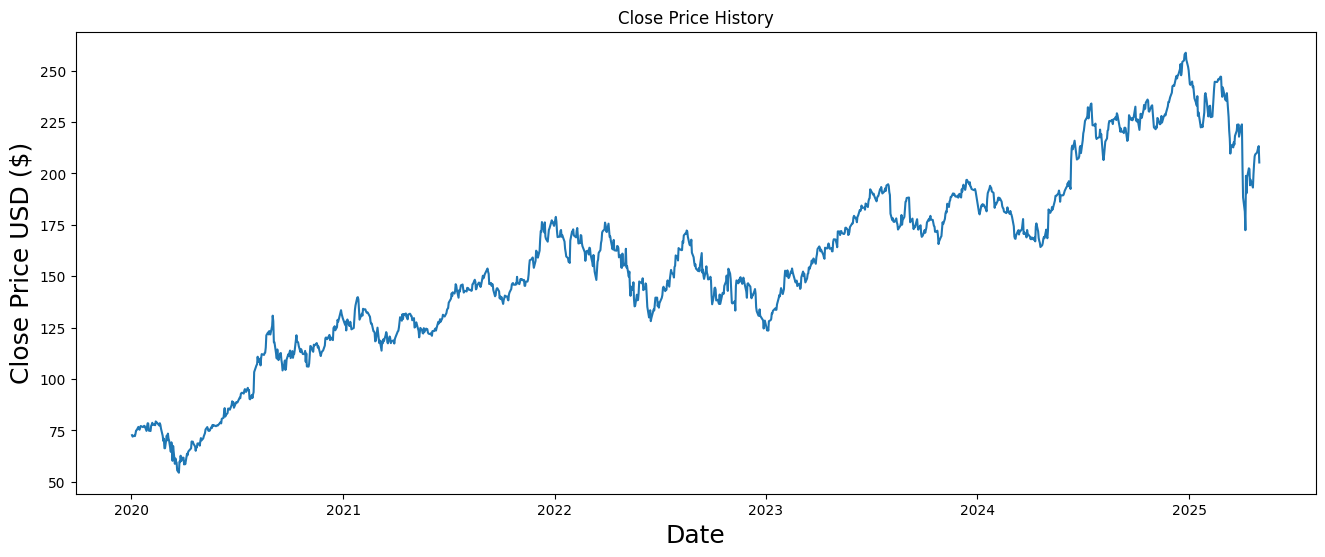

In [26]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()
# plt.savefig("close_price.png")  

In [27]:
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [28]:
data = df['Close']['AAPL']
dataset = data.values
dataset = data.values.reshape(-1, 1)

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95))

In [29]:
data.head()

Date
2020-01-02    72.716080
2020-01-03    72.009140
2020-01-06    72.582901
2020-01-07    72.241554
2020-01-08    73.403633
Name: AAPL, dtype: float64

In [30]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))




[array([0.08941491, 0.08595436, 0.08876298, 0.08709205, 0.09278055,
       0.10041284, 0.10124246, 0.10909976, 0.10402752, 0.10243938,
       0.10706145, 0.11119749, 0.10863748, 0.10997681, 0.1117901 ,
       0.11069973, 0.09960708, 0.10996501, 0.11784598, 0.117289  ,
       0.1002707 , 0.09926331, 0.11133966, 0.1144211 , 0.11887709,
       0.11363835, 0.11544399, 0.11313937, 0.12215583, 0.11938795,
       0.11948304, 0.11241476, 0.11790294, 0.11395905, 0.10534649,
       0.0876818 , 0.07568353, 0.08111247, 0.05838723, 0.05819717,
       0.08843019, 0.07715671, 0.09309875, 0.08143321, 0.07681215,
       0.04965586, 0.07242865, 0.06065626, 0.02834421, 0.06367361,
       0.0211928 , 0.03384437, 0.02649105, 0.02424582, 0.00578525,
       0.        , 0.02674047, 0.02512492, 0.04047311, 0.0277621 ])]
[0.036160855627994704]

[array([0.08941491, 0.08595436, 0.08876298, 0.08709205, 0.09278055,
       0.10041284, 0.10124246, 0.10909976, 0.10402752, 0.10243938,
       0.10706145, 0.11119749, 0.1

In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)
# x_train.shape

# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("error:", rmse)


/Users/rachel/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0059
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x30d49bec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
error: 10.485036012830012


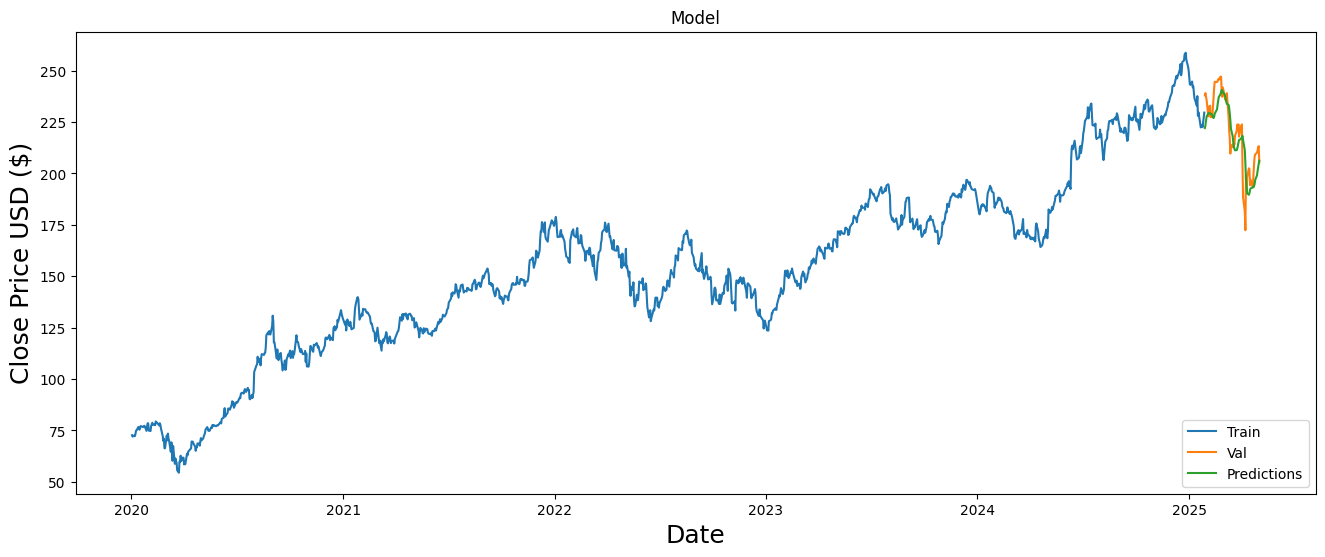

In [32]:
dates = data.index

# Convert dataset (scaled or unscaled) back to a DataFrame
dataset_df = pd.DataFrame(dataset, index=dates, columns=['Close'])

# Split into train and valid DataFrames
train = dataset_df[:training_data_len]
valid = dataset_df[training_data_len:].copy()

# Add predictions to valid set (make sure predictions is same length)
valid['Predictions'] = predictions

# Plot the results
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [33]:
valid

,Close,Predictions
Date,,
2025-01-28,237.998322,222.095932
2025-01-29,239.097122,223.473129
2025-01-30,237.329056,225.626877
2025-01-31,235.740814,227.688156
2025-02-03,227.759583,229.256561
...,...,...
2025-04-28,210.139999,199.038452
2025-04-29,211.210007,201.083466
2025-04-30,212.500000,202.972366
